# Stocks RNN Predictor

By: Kesavar Kabilar, Ryan James Laporte, and Carmelo Restivo-Caponcello

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
np.random.seed(7)

In [4]:
data_path = "/content/gdrive/My Drive/Project/Stocks/" # Change file directory

In [5]:
def get_all_files(data_path=data_path):
    """
    Given a path to the stocks data, this function will return the file 
    locations of companies consisting of at least 100 lines of previous stocks 
    data.
    """
    all_files = []

    for file in os.listdir(data_path)[:100]:
        f = open(data_path+file)
        if len(f.readlines()) > 100: 
            all_files.append(data_path+file)
        f.close()
    
    return all_files

all_files = get_all_files()

In [6]:
n = len(all_files)

all_files = np.array(all_files, dtype=str)
np.random.shuffle(all_files)

training_files = all_files[:int(n*0.6)] 
validation_files = all_files[int(n*0.6):int(n*0.8)]
test_files = all_files[int(n*0.8):]

In [7]:
def transform_data(file, K, augment=False):
    """
    Given a file, a K value it will return X, T. Each row of X contains K x 4 
    values where each row represents the open value, highest price, lowest 
    price, and the closing price. Each column represent the previous K days. 
    Each row of T represents the closing price of K+1 day. If augment is true, 
    the function will also add the reverse of the days.
    """
    X, T = [], []

    f = open(file, "r")

    all_data = []

    data = []
    for line in f.readlines()[-100:]:
        line = line.split(",")[1:-2]
        all_data.append(line)

        data.append(line)
        if len(data) == K+1:
            x = np.array(data[:-1], dtype=float)
            X.append(x)
            T.append(float(data[-1][-1]))

            data = data[1:]

    f.close()
    if augment:
        data = []
        for line in all_data[::-1]:

            data.append(line)
            if len(data) == K+1:
                x = np.array(data[:-1], dtype=float)
                X.append(x)
                T.append(float(data[-1][-1]))

                data = data[1:]
    
    return torch.tensor(np.array(X), dtype=torch.float), torch.tensor(np.array(T), dtype=torch.float)

In [8]:
class StocksRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # normalize input
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        # RNN Layer
        out, _ = self.rnn(x)
        # Fully connected layer
        out = self.fc(out[:, -1, :])
        # Denormalize output
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)

class StocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(StocksLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # normalize input
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s2*s3)
        min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
        x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
        x = x.reshape(s1, s2, s3)
        # LSTM Layer
        out, _ = self.lstm(x)
        # Fully connected layer
        out = self.fc(out[:, -1, :])
        # Denormalize output
        return ((out.reshape(-1) * (max-min)) + min).reshape(-1, 1)


In [9]:
def get_mean_squared_error(model, files, K, incrDecr=False):
    """
    Given the model, a set of files, and K value, The function will calculate 
    the mean squared error of the dataset.
    """
    error = 0
    total = 0

    for f in files:
        x, t = transform_data(f, K)
        
        if incrDecr:
            output = model(x).reshape(-1)

            t[np.where(x[:, -1, -1] >= t)] = 0
            t[np.where(x[:, -1, -1] < t)] = 1
            output[np.where(x[:, -1, -1] >= output)] = 0
            output[np.where(x[:, -1, -1] < output)] = 1

        else:
            s1, s2, s3 = x.shape
            x = x.reshape(s1, s2*s3)
            min, max = torch.amin(x, axis=1), torch.amax(x, axis=1)
            x = (x-min[:, np.newaxis]) / (max[:, np.newaxis] - min[:, np.newaxis])
            x = x.reshape(s1, s2, s3)
            t = (t-min) / (max - min)

            output = model(x).reshape(-1)

        error += int(sum((output - t)**2).detach())
        total += output.shape[0]

    return error / total

In [10]:
def train_rnn_network(model, train, valid, num_epochs, batch_size, learning_rate, K, name, augment=False):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    iter_x = []
    iter_t = []
    for f in train:
        x, t = transform_data(f, K, augment)
        iter_x.append(x)
        iter_t.append(t)

    train_data_x = torch.concat(iter_x, 0)
    train_data_t = torch.concat(iter_t, 0)

    for epoch in range(num_epochs):

        p = np.random.permutation(train_data_t.shape[0])
        X, T = train_data_x[p], train_data_t[p]

        for i in range(0, int(T.shape[0]), batch_size):
            batch_x = X[i: (i+batch_size)]
            batch_t = T[i: (i+batch_size)]
            pred = model(batch_x)
            loss = criterion(pred, batch_t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_mean_squared_error(model, train, K))
        valid_acc.append(get_mean_squared_error(model, valid, K))
        if (epoch+1) % 10 == 0:
            print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    plt.title(name + " Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.legend(loc='best')
    plt.savefig(name.replace(" ", "")+".png")
    plt.show()

Epoch 10; Loss 0.694763; Train Acc 0.418713; Val Acc 0.438596
Epoch 20; Loss 0.770645; Train Acc 0.330019; Val Acc 0.337427
Epoch 30; Loss 1.052793; Train Acc 0.271540; Val Acc 0.269006
Epoch 40; Loss 0.640065; Train Acc 0.251852; Val Acc 0.241520
Epoch 50; Loss 0.634977; Train Acc 0.249903; Val Acc 0.234503
Epoch 60; Loss 0.695539; Train Acc 0.248148; Val Acc 0.230994
Epoch 70; Loss 0.433822; Train Acc 0.242885; Val Acc 0.227485
Epoch 80; Loss 0.535720; Train Acc 0.240351; Val Acc 0.225731
Epoch 90; Loss 0.598736; Train Acc 0.238012; Val Acc 0.222807
Epoch 100; Loss 1.063134; Train Acc 0.234503; Val Acc 0.218713


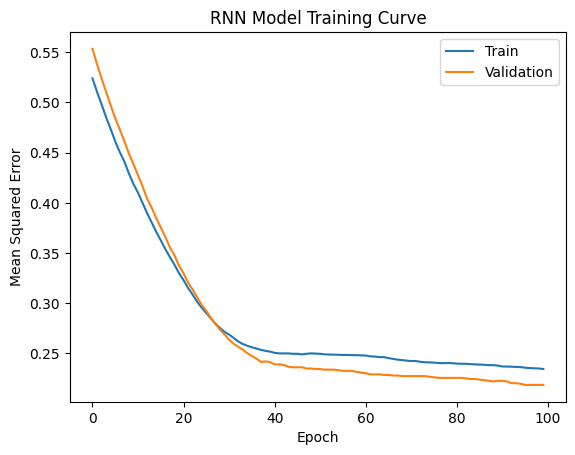

Test Data Accuracy:  0.2033240997229917
Test Data Increase/Decrease Accuracy:  0.45761772853185595


In [11]:
modelRNN = StocksRNN(4, 150)
train_rnn_network(modelRNN, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5, 
                  name="RNN Model")
print("Test Data Error: ", get_mean_squared_error(modelRNN, test_files, 5))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelRNN, test_files, 5, incrDecr=True))

Epoch 10; Loss 1.604393; Train Acc 0.459454; Val Acc 0.480117
Epoch 20; Loss 0.772835; Train Acc 0.429045; Val Acc 0.447953
Epoch 30; Loss 1.015798; Train Acc 0.400000; Val Acc 0.415205
Epoch 40; Loss 0.767608; Train Acc 0.369201; Val Acc 0.381287
Epoch 50; Loss 0.609198; Train Acc 0.339376; Val Acc 0.346784
Epoch 60; Loss 0.799616; Train Acc 0.310526; Val Acc 0.314620
Epoch 70; Loss 0.374642; Train Acc 0.285185; Val Acc 0.284795
Epoch 80; Loss 0.545906; Train Acc 0.265692; Val Acc 0.260234
Epoch 90; Loss 0.246743; Train Acc 0.255166; Val Acc 0.245029
Epoch 100; Loss 1.211784; Train Acc 0.249903; Val Acc 0.236842


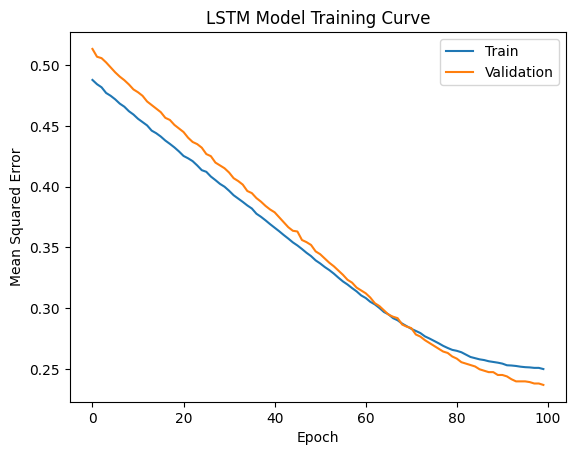

Test Data Accuracy:  0.2188365650969529
Test Data Increase/Decrease Accuracy:  0.4476454293628809


In [12]:
modelLSTM = StocksLSTM(4, 150)
train_rnn_network(modelLSTM, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5, 
                  name="LSTM Model")
print("Test Data Accuracy: ", get_mean_squared_error(modelLSTM, test_files, 5))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelLSTM, test_files, 5, incrDecr=True))

Epoch 10; Loss 0.722071; Train Acc 0.284405; Val Acc 0.283626
Epoch 20; Loss 0.428138; Train Acc 0.240936; Val Acc 0.230409
Epoch 30; Loss 0.328664; Train Acc 0.232359; Val Acc 0.219883
Epoch 40; Loss 1.124077; Train Acc 0.224951; Val Acc 0.210526
Epoch 50; Loss 0.214118; Train Acc 0.219298; Val Acc 0.205848
Epoch 60; Loss 0.202942; Train Acc 0.215400; Val Acc 0.201754
Epoch 70; Loss 0.723381; Train Acc 0.213255; Val Acc 0.199415
Epoch 80; Loss 0.331023; Train Acc 0.211696; Val Acc 0.198830
Epoch 90; Loss 0.170941; Train Acc 0.210916; Val Acc 0.198246
Epoch 100; Loss 0.251547; Train Acc 0.209942; Val Acc 0.196491


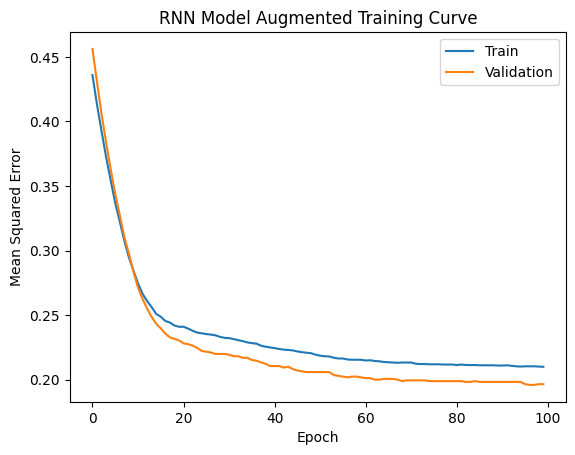

Test Data Accuracy:  0.2033240997229917
Test Data Increase/Decrease Accuracy:  0.43988919667590026


In [13]:
modelRNNAug = StocksRNN(4, 150)
train_rnn_network(modelRNNAug, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5, 
                  name="RNN Model Augmented", 
                  augment=True)
print("Test Data Accuracy: ", get_mean_squared_error(modelRNN, test_files, 5))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelRNNAug, test_files, 5, incrDecr=True))

Epoch 10; Loss 1.581729; Train Acc 0.438012; Val Acc 0.456725
Epoch 20; Loss 0.877615; Train Acc 0.370760; Val Acc 0.381287
Epoch 30; Loss 0.323645; Train Acc 0.307212; Val Acc 0.310526
Epoch 40; Loss 0.739534; Train Acc 0.265887; Val Acc 0.260234
Epoch 50; Loss 0.645037; Train Acc 0.252437; Val Acc 0.239766
Epoch 60; Loss 0.303138; Train Acc 0.248733; Val Acc 0.236842
Epoch 70; Loss 0.698053; Train Acc 0.245614; Val Acc 0.233918
Epoch 80; Loss 0.333213; Train Acc 0.243665; Val Acc 0.229825
Epoch 90; Loss 0.297799; Train Acc 0.241326; Val Acc 0.228070
Epoch 100; Loss 0.265401; Train Acc 0.238207; Val Acc 0.223977


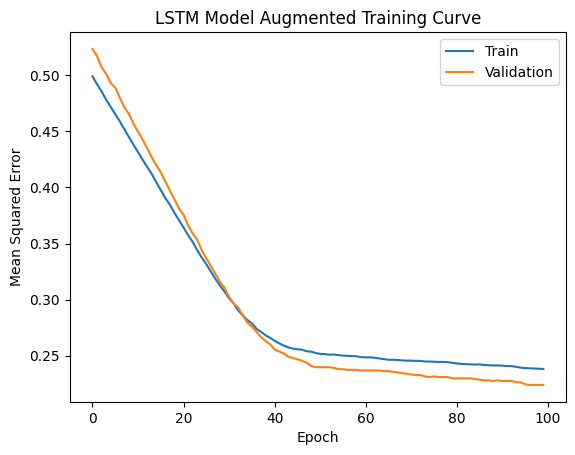

Test Data Accuracy:  0.2033240997229917
Test Data Increase/Decrease Accuracy:  0.4515235457063712


In [14]:
modelLSTMAug = StocksLSTM(4, 150)
train_rnn_network(modelLSTMAug, 
                  training_files, 
                  validation_files, 
                  num_epochs=100, 
                  batch_size=500, 
                  learning_rate=1e-5,
                  K=5, 
                  name="LSTM Model Augmented", 
                  augment=True)
print("Test Data Accuracy: ", get_mean_squared_error(modelRNN, test_files, 5))
print("Test Data Increase/Decrease Accuracy: ", get_mean_squared_error(modelLSTMAug, test_files, 5, incrDecr=True))

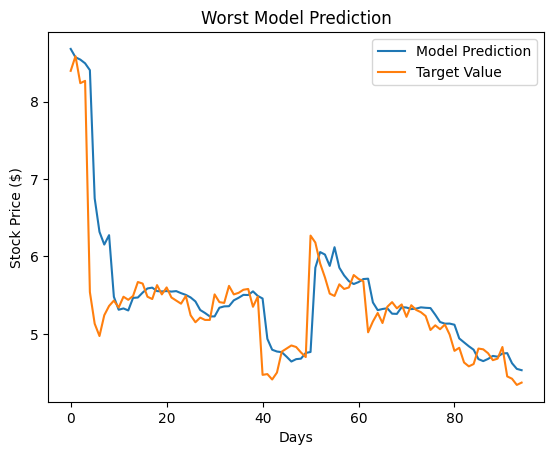

Worst Model Prediction Error:  0.6526315789473685


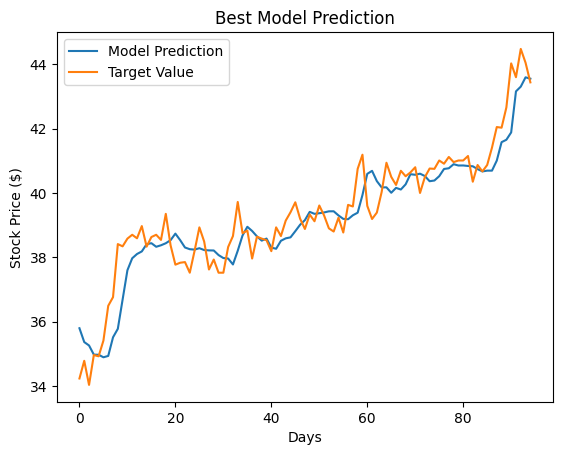

Best Model Prediction Error:  0.12631578947368421


In [15]:
def goodBadExample(model, K, test_files=test_files):
    """
    Given a model, K, and test_files dataset, this function will output the 
    company with the worst mean squared error and the company with the best 
    mean squared error. Display a graph for which it least correctly predicted 
    the values and a graph for which it most correctly predicted the values.
    """
    bad_error, bad_file = float("-inf"), ""
    good_error, good_file = float("inf"), ""

    for f in test_files:
        error = get_mean_squared_error(modelLSTM, [f], K)
        if error > bad_error:
            bad_error = error
            bad_file = f
        
        if error < good_error:
            good_error = error
            good_file = f

    X, T = transform_data(good_file, K)
    Y = model(X)

    plt.title("Best Model Prediction")
    plt.ylabel("Stock Price ($)")
    plt.xlabel("Days")
    plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="Model Prediction")
    plt.plot(np.arange(len(T)), T, label="Target Value")
    plt.legend()
    plt.savefig("BestModelPrediction.png")
    plt.show()

    print("Best Model Prediction Error: ", 
          get_mean_squared_error(modelLSTM, [good_file], K))

    X, T = transform_data(bad_file, K)
    Y = model(X)

    plt.title("Worst Model Prediction")
    plt.ylabel("Stock Price ($)")
    plt.xlabel("Days")
    plt.plot(np.arange(len(Y)), Y.detach().numpy(), label="Model Prediction")
    plt.plot(np.arange(len(T)), T, label="Target Value")
    plt.legend()
    plt.savefig("WorstModelPrediction.png")
    plt.show()

    print("Worst Model Prediction Error: ", 
          get_mean_squared_error(modelLSTM, [bad_file], K))

goodBadExample(modelRNN, 5, test_files=test_files)